In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
parent_path = str(Path().joinpath('..\..\..\..').resolve())
sys.path.append(parent_path)

In [3]:
from triple_agent.parsing.replay.get_parsed_replays import get_parsed_replays
from triple_agent.constants.events import select_sc19
from triple_agent.reports.specific.character_selection import (spy_selection,
                                                      st_selection,
                                                      amba_selection,
                                                      double_agent_selection,
                                                      determine_character_in_role)
from triple_agent.reports.specific.game_outcomes import game_outcomes
from triple_agent.classes.roles import Roles
from triple_agent.classes.characters import Characters
from triple_agent.classes.outcomes import WinType
from triple_agent.classes.missions import Missions, MissionStatus
from triple_agent.reports.generation.common_sort_functions import sort_by_spy_wins, sort_by_sniper_wins
from triple_agent.reports.generation.plot_specs import AxisProperties, DataQueryProperties, PlotLabelStyle
from triple_agent.reports.specific.action_tests import action_test_percentages, diff_action_test_percentages
from triple_agent.reports.specific.mission_choices import mission_choices
from triple_agent.reports.specific.mission_completes import (mission_completion_query,
     mission_completion,
    _mission_completes_details)
from triple_agent.classes.action_tests import ActionTest
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import linregress
from itertools import groupby

In [4]:
replays = get_parsed_replays(lambda g: True)

In [5]:
first_game_dates = dict()
for event, games in groupby(sorted(replays, key=lambda g: g.event), key=lambda g2: g2.event):
    date_sorted = sorted(games, key=lambda g3: g3.start_time)
    first_game_dates[event] = date_sorted[0].start_time

# This will create a list ordering each event by the date of the first game played
EVENT_ORDER = [event for event, date in sorted(first_game_dates.items(), key=lambda fgd: fgd[1])]

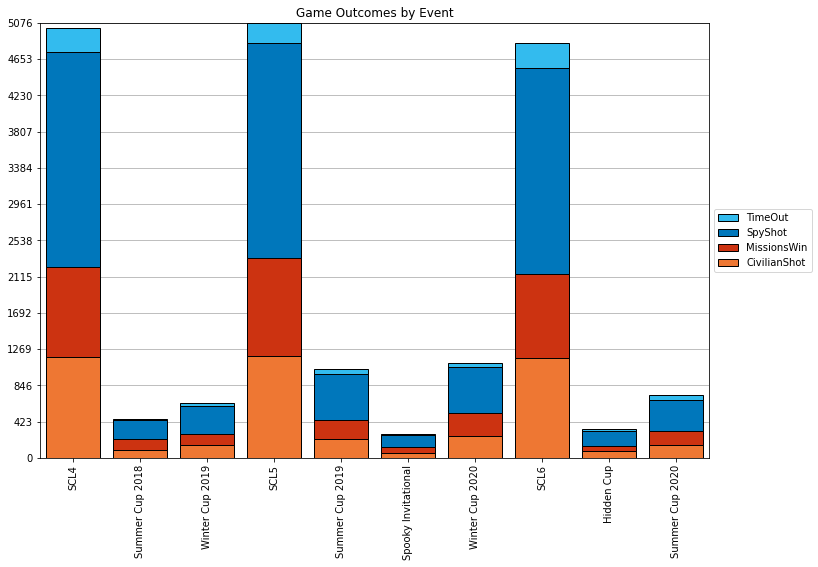

,SCL4,Summer Cup 2018,Winter Cup 2019,SCL5,Summer Cup 2019,Spooky Invitational,Winter Cup 2020,SCL6,Hidden Cup,Summer Cup 2020
WinType.TimeOut,282,12,39,230,57,12,46,293,21,52
WinType.SpyShot,2507,218,323,2508,537,141,528,2411,171,368
WinType.MissionsWin,1043,127,133,1145,221,68,273,980,61,153
WinType.CivilianShot,1182,93,144,1192,222,57,255,1160,79,155


In [6]:
game_outcomes(
    replays,
    DataQueryProperties(
        groupby=lambda g: g.event,
        secondary_order=EVENT_ORDER,
    ),
    axis_properties=AxisProperties(title="Game Outcomes by Event")
).frame

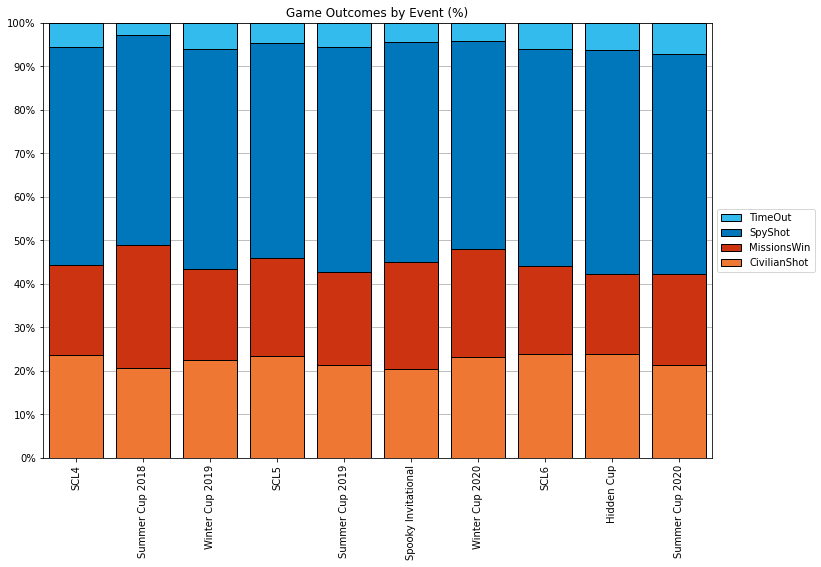

,SCL4,Summer Cup 2018,Winter Cup 2019,SCL5,Summer Cup 2019,Spooky Invitational,Winter Cup 2020,SCL6,Hidden Cup,Summer Cup 2020
WinType.TimeOut,0.056243,0.026667,0.061033,0.045320,0.054966,0.043165,0.041742,0.060487,0.063253,0.071429
WinType.SpyShot,0.500000,0.484444,0.505477,0.494187,0.517840,0.507194,0.479129,0.497729,0.515060,0.505495
WinType.MissionsWin,0.208018,0.282222,0.208138,0.225616,0.213115,0.244604,0.247731,0.202312,0.183735,0.210165
WinType.CivilianShot,0.235740,0.206667,0.225352,0.234877,0.214079,0.205036,0.231397,0.239472,0.237952,0.212912


In [7]:
game_outcomes(
    replays,
    DataQueryProperties(
        groupby=lambda g: g.event,
        secondary_order=EVENT_ORDER,
        percent_normalized_data=True,
    ),
    axis_properties=AxisProperties(
        title="Game Outcomes by Event (%)",
    )
).frame

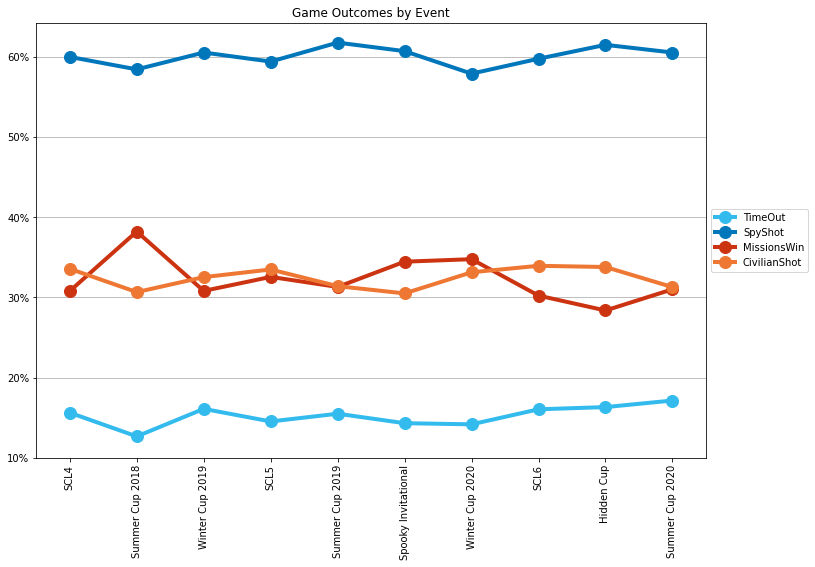

,SCL4,Summer Cup 2018,Winter Cup 2019,SCL5,Summer Cup 2019,Spooky Invitational,Winter Cup 2020,SCL6,Hidden Cup,Summer Cup 2020
WinType.TimeOut,0.056243,0.026667,0.061033,0.045320,0.054966,0.043165,0.041742,0.060487,0.063253,0.071429
WinType.SpyShot,0.500000,0.484444,0.505477,0.494187,0.517840,0.507194,0.479129,0.497729,0.515060,0.505495
WinType.MissionsWin,0.208018,0.282222,0.208138,0.225616,0.213115,0.244604,0.247731,0.202312,0.183735,0.210165
WinType.CivilianShot,0.235740,0.206667,0.225352,0.234877,0.214079,0.205036,0.231397,0.239472,0.237952,0.212912


In [8]:
game_outcomes(
    replays,
    DataQueryProperties(
        groupby=lambda g: g.event,
        secondary_order=EVENT_ORDER,
        percent_normalized_data=True
    ),
    axis_properties=AxisProperties(
        title="Game Outcomes by Event",
        force_line=True,
    )
).frame

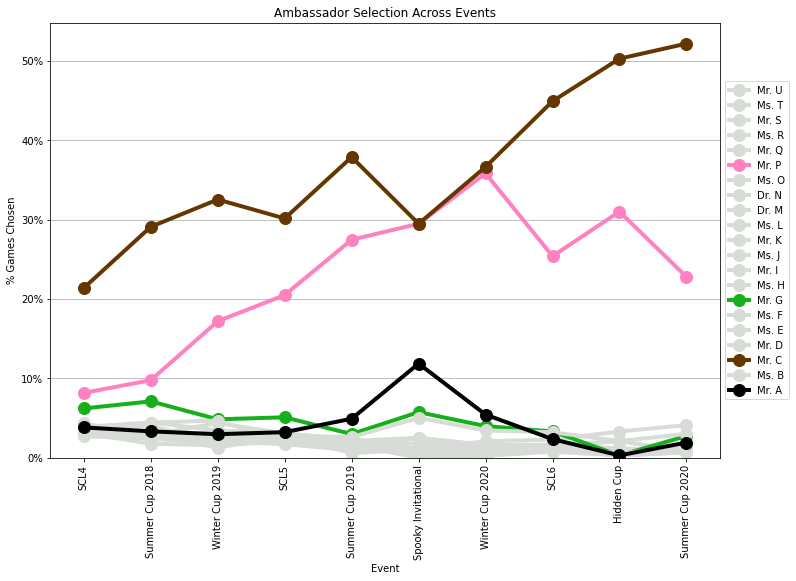

In [9]:
_=amba_selection(
    replays,
    axis_properties = AxisProperties(
        title="Ambassador Selection Across Events",
        y_axis_label="% Games Chosen",
        x_axis_label="Event",
        force_line=True,
        primary_color_dict=defaultdict(lambda: 'xkcd:light grey', {
            Characters.Taft:'xkcd:brown',
            Characters.Carlos:'xkcd:pink',
            Characters.General:'xkcd:green',
            Characters.Disney:'black'})
    ),
    data_query = DataQueryProperties(
        groupby=lambda g: g.event,
        secondary_order=EVENT_ORDER,
        percent_normalized_data=True,
    )
).frame